In [1]:
import numpy as np
import matplotlib.pyplot as plt

# the pylj guide

Welcome to the guide for how to use pylj. The document will focus on how to get pylj running, the pedagogical aspects of the code, and give some examples of how pylj could be used in teaching of classical simulation to undergraduate chemistry and physics students. There is some assumed knowledge:

- you have some familiarity with the Jupyter notebooks framework (in that you were able to install Jupyter and open this notebook
- you have enough familiarity with Python to be able to install packages either via pip or from source. 

## how to get pylj?

The first thing to do is to get a copy of pylj running on your computer. pylj is available on the pypi package manager so it is possible to install pylj (and all of it's dependencies) using the following command,

```
pip install pylj 
```

in either the terminal (macOS or Linux) or the appropriate interface on Windows (e.g. Anaconda Prompt). It is also possible to install pylj from source by cloning the git repository and installing as follows (in the pylj main directory, 

```
pip install -r requirements.txt

python setup.py build

python setup.py install

python setup.py test
```

The former method is preferred as the latter will install the (possibly) unstable development version of pylj. 

## what is pylj?

Often is it difficult to introduce students (at both undergraduate and postgraduate level) to atomistic and molecular simulation due to the relatively high entry barrier (it is necessary to have some knowledge of lost arts such as the command line or programming). pylj aims to lower this barrier by allowing students to interact with a (simple) atomistic simulation with relative ease, while introducing ideas of programming. 

pylj is a simple tool that is capable of performing the two-dimensional simulation of particles interacting via a [Lennard-Jones potential](https://en.wikipedia.org/wiki/Lennard-Jones_potential), which essentially models the Paluli exclusion principle at short distances and the van der Waals attraction over long distances. The function used within pylj to determine the total energy of the system is as follows,

$$ E_{\text{total}}  = \begin{cases}
\sum_{\mathbf{r}}\bigg(\frac{A}{\mathbf{r}^{12}} - \frac{B}{\mathbf{r}^6}\bigg),& \text{if }\mathbf{r} < \text{cut-off}\\
0, & \text{otherwise}
\end{cases}
$$

where, $A = 1.363\times10^{-134}\;\text{Jm}^{12}$, $B = 9.273\times10^{-78}\;\text{Jm}^6$, and $\mathbf{r}$ is the distances between the pairs of particles (in pylj the cut-off is defaults to 15 Å, however may be varied). The values of $A$ and $B$ were taken from those determined for particles of argon by Rahman[1]. The result is a energy profile for a pair of particle that looks like this, 

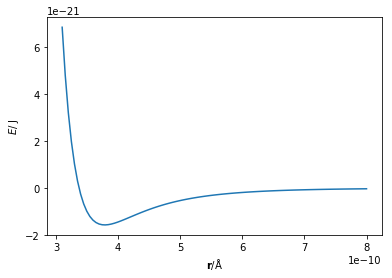

In [2]:
def e(r): 
    return 1.363e-134 / np.power(r, 12.) - 9.273e-78 / np.power(r, 6.)

r = np.linspace(3.1e-10, 8e-10, 100)
plt.plot(r, e(r))
plt.xlabel('$\mathbf{r}$/Å')
plt.ylabel('$E$/ J')
plt.show()

pylj is capable of running both molecular dynamics and Monte-Carlo simulations using built in functions, but could be extended to cover any simulation method that uses the Lennard-Jones potential. 

### visualisation

One of the most powerful aspects of pylj as a teaching tool is the visualisation environment. pylj is written to allow for the easy access to a series of commonly desired simulation output, such as instanteous pressure, temperature, and radial distribution funciton. These are all available through the use of a sampling class, these can either be those packaged with pylj, such as the Interactions or RDF classes, or can be custom built to the specification of the educator. More information about the sampling class and the sample module is available [here](http://pylj.readthedocs.io/en/latest/visualisation.html). 

## how to teach with pylj?

The current vision of pylj involves its application in a teaching laboratory setting (however there are may other applications available), and through this vision we have lead to two main areas that pylj could be used:

1. teaching about simulation algorithms, the mechanics of simulation and allowing the students to build a simulation themselves,
2. showing how simulation can be used to study physical attributes of chemical systems, consolidating learning introduced as lecture material. 

We will introduce both of this, as they are link, although neither are reliant on the other. 

### simulation algorithms 

A common aspect of a final-year undergraduate degree is a course introducing simulation techniques, in particular molecular dynamics and Monte Carlo. In an effort to build on lecture material, it is possible to apply pylj as a tool to introduce these techniques in an interactive learning environment. 

#### molecular dynamics 

Typically molecular dynamics is taught as consisting of the following algorithm, 

1. initialise the system,
2. start the clock, 
3. calculate the forces of each particle,
4. integrate Newton's equations of motion to step forward in time,
5. sample the system,
6. go to 3.

This would look as follows in pylj. 

In [3]:
from pylj import md, sample, comp

def md_simulation(number_of_particles, temperature, box_length, number_of_steps, sample_frequency):
    # Creates the visualisation environment
    %matplotlib notebook
    # Initialise the system
    system = md.initialise(number_of_particles, temperature, box_length, 'square')
    # This sets the sampling class
    sample_system = sample.Interactions(system)
    # Start at time 0
    system.time = 0
    # Begin the molecular dynamics loop
    for i in range(0, number_of_steps):
        # At each step, calculate the forces on each particle and get acceleration
        system.particles, system.distances, system.forces, system.energies = comp.compute_forces(system.particles, 
                                                                                                 system.box_length, 
                                                                                                 system.cut_off)
        # Run the equations of motion integrator algorithm
        system.particles = md.velocity_verlet(system.particles, system.timestep_length, system.box_length, 
                                              system.cut_off)
        # Sample the thermodynamic and structural parameters of the system
        system = md.sample(system.particles, system.box_length, system.initial_particles, system)
        # Iterate the time
        system.time += system.timestep_length
        system.step += 1
        # At a given frequency sample the positions and update the plots
        if system.step % sample_frequency == 0:
            sample_system.update(system)
    return system

Hopefully it is clear that there are a wide variety of teaching aspects available within this algorithm alone, possible discussions include (but are not limited to):

- initialising the system on a square lattice versus a random positioning. Often the random positioning will result in the system exploding as the forces are too great,
- as this is an NVE ensemble it could be discussed how the temperature of the system is not that anticipated,
- the conversion to an NVT ensemble using the [`comp.heat_bath`](http://pylj.readthedocs.io/en/latest/comp.html#pylj.comp.heat_bath) function in the sampling stage,
- the discussion of different integrators, currently pylj only really supports [Velocity-Verlet](https://en.wikipedia.org/wiki/Verlet_integration#Velocity_Verlet) however there is nothing to stop students from writing their own integrator function.

It is possible to quickly see the above function in action below.

<IPython.core.display.Javascript object>


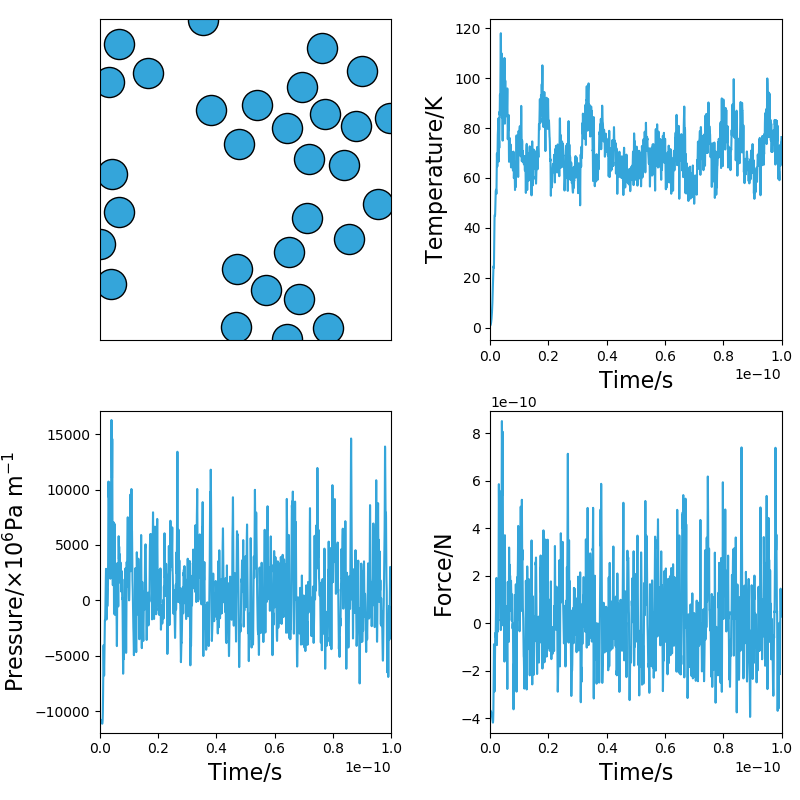

In [4]:
simulation1 = md_simulation(30, 100, 30, 10000, 100)

#### monte carlo

Monte Carlo simulations are often taught in a similar fashion to molecular dynamics, with the introduction of an algorithm, 

1. initialise the system,
2. calculate the energy of the system,
3. suggest some change to the system,
4. calculate the energy with this change,
5. if some condition is true, accept the change,
6. go to step 2.

Again it is straightforward to impliment this in pylj, as follows. 

In [5]:
from pylj import mc

def mc_simulation(number_of_particles, temperature, box_length, number_of_steps, sample_frequency):
    # Creates the visualisation environment
    %matplotlib notebook
    # Initialise the system placing the particles on a square lattice
    system = mc.initialise(number_of_particles, temperature, box_length, 'square')
    # This sets the sampling class as Energy, which shows the energy of the system
    sample_system = sample.Energy(system)
    # Compute the energy of the system
    system.particles, system.distances, system.energies = comp.compute_energy(system.particles, 
                                                                              system.box_length,
                                                                              system.cut_off)
    old_energy = system.energies.sum()
    # Add this energy to the energy sample array
    system = mc.sample(old_energy, system)
    # Begin the monte carlo loop
    for i in range(0, number_of_steps):
        system.step += 1
        # Select a random particle to remove
        random_particle, system.position_store = mc.select_random_particle(system.particles)
        # Select a random position to replace that particle
        system.particles = mc.get_new_particle(system.particles, random_particle, system.box_length)
        # Compute the new energy of the system
        system.particles, system.distances, system.energies = comp.compute_energy(system.particles, 
                                                                                  system.box_length, 
                                                                                  system.cut_off)
        new_energy = system.energies.sum()
        # Assess the Metropolis condition
        if mc.metropolis(temperature, old_energy, new_energy):
            old_energy = mc.accept(new_energy)
        else:
            system.particles = mc.reject(system.position_store, system.particles, random_particle)
        # Add this energy to the energy sample array
        system = mc.sample(old_energy, system)
        # At a given frequency sample the positions and plot
        if system.step % sample_frequency == 0:
            sample_system.update(system)
    return system

In this example, the condition that must be true is the Metropolis condition. Again there are a clear number of teaching points within this algorithm:

- changing the condition, such as a simple energy minimisation,
- varying the temperature to show how the Metropolis condition allows for intrinsic thermostating,
- again varying the starting configuration of the atoms,
- implimenting a grand-canonical ensemble.

Again the above function can be seen in action below. 

<IPython.core.display.Javascript object>


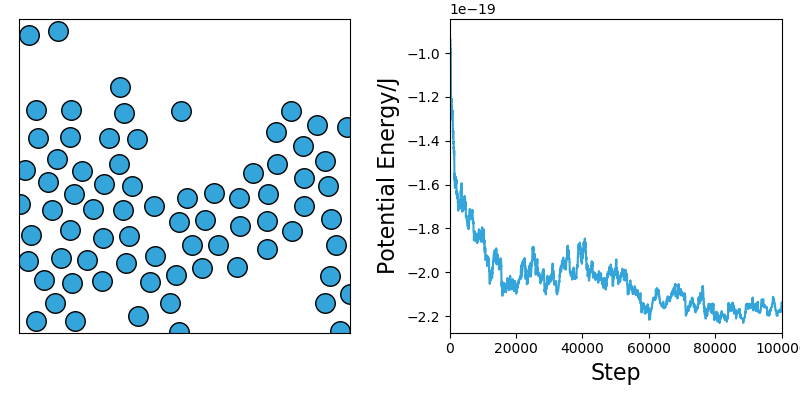

In [6]:
system = mc_simulation(75, 100, 45, 100000, 100)

### using simulation

The other track to use pylj in teaching would be to show the ability for simulation to probe physical properties of chemical systems. Two examples of this that pylj has been applied to previously are: 

- probing the properties of argon at gas and liquid densities, showing where the ideal gas law is valid and where it breaks down,
- observing the effect of the liquid to solid transition on the resulting diffraction pattern.

The ideal gas law example has been written into a full undergraduate laboratory exercise and can be downloaded [here](https://github.com/arm61/pylj/tree/master/examples/ideal_gas_law). In this exercise, the student is introduced to classical simulation, Lennard-Jones potential, and molecular dynamics. A function is then given to allow the student to perform a NVT molecular dynamics simulation, and the student is asked to probe the effect of temperature on the energy of the system, the effect of density on the radial distribution function and the effect of density on the ideal gas law, showing that it breaks down at the gas-liquid transition. The student is then introduced to the van der Waals equation and given the opportunity to use it to rationalise the observed deviation from the ideal gas law. 

The other example has been used previously in a lecture environment, at the ISIS Neutron Training Course during a lecture on molecular simulation, which can be found [here](https://github.com/bjmorgan/python_in_chemistry/tree/master/Neutron_Training_Course). In this, the students were shown the pylj simulations along with the Scattering sampling class, which shows the diffraction profile for the system under study. The aim of this application was to show the students attending the course (who were unfamiliar with classical simulation) the possible links between simulation and experiment, pylj was able to provide a simple interface to allow for this.

1. [A. Rahman "Correlations in the Motion of Atoms in Liquid Argon", Physical Review 136 pp. A405–A411 (1964)](http://dx.doi.org/10.1103/PhysRev.136.A405)